# Setup

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [2]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [15]:
# directory_path = Path(settings_dict['save_dir'])
directory_path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Mark_C/Spine_Density_Annotation/from_local_drive')#annotated cells from local desktop')#returned from main network folder/')#474111084/')
cell_filepaths = get_cell_filepaths(directory_path) # gets filepaths for all cells in a directory"

# Get annotations

In [16]:
cellids = ['214581797', #mg2
           '393325331', #lf
           '301787806',
           '299496636',
           '307418797'
]

# ['214581797', #mg2 (" I think that one was sg1" as per mark)
#            '393325331', #lf
#            '474111084' #mg1, but not one of the main example cells#
#           ]#['213528973','556969316','474111084','562815622','567566839']

In [17]:
cell_filepaths['393325331']

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Mark_C/Spine_Density_Annotation/from_local_drive/cell_graph_393325331__2024-02-07 10.14.07_old.json')

In [18]:
id_ = '393325331'
cell = ecrest(settings_dict,filepath = cell_filepaths[id_], launch_viewer=True)

updating viewer status message: Current Base Segment Counts: unknown: 4858, axon: 0, basal dendrite: 0, apical dendrite: 0, dendrite: 0, multiple: 0


In [7]:
anno_loc = 'spineD loc'
anno_pts = 'spineD pts'
vx_sizes = [16, 16, 30]
'''assumes that the annotation is a point annotation stored in the list as ([x,y,z,segment_id],'annotatePoint')
                previous ot Jan 25 2024, it was just [x,y,z,segment_id]'''

data = []

for id_ in cellids:
    # id_ = cellids[0]
    
    cell = ecrest(settings_dict,filepath = cell_filepaths[id_])
    
    ctype = cell.get_ctype("manual")
    

    
    for loc_ in cell.cell_data['end_points'][anno_loc]:
        x,y,z = [p/1000 for p in loc_[0]]             
    
        d = [np.linalg.norm(np.array(pt_[0]) - np.array(loc_[0])) for pt_ in cell.cell_data['end_points'][anno_pts] if (np.linalg.norm(np.array(pt_[0]) - np.array(loc_[0])))<5100]
        
        data.append({'id': id_, 'cell_type': ctype, 'x': x, 'y': y, 'z': z, 'n': len(d)})#, ignore_index=True)

df = pd.DataFrame(data)

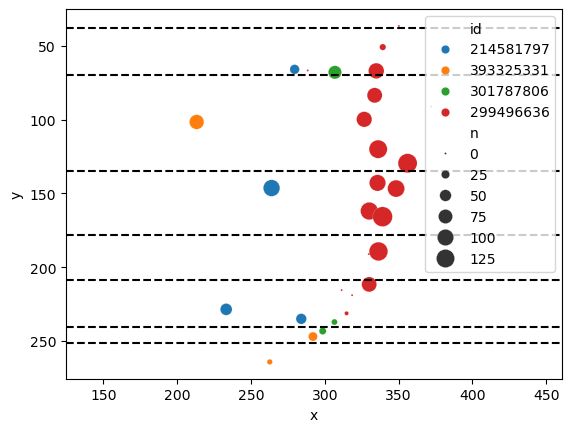

In [8]:
ax = sns.scatterplot(data=df,x='x',y='y',size='n',hue='id',sizes=(2, 200))
ax.set_aspect('equal', adjustable='datalim')
for y_ in [2365*16, 4344*16, 8432*16, 11138*16, 13021*16, 15045*16, 15700*16]:
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
ax.invert_yaxis()


/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_22128/2467873383.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df,x='n',hue='id',cut=0)


<Axes: xlabel='n', ylabel='Density'>

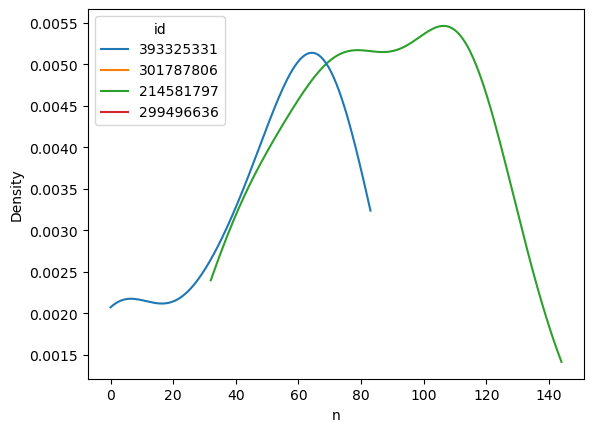

In [7]:
sns.kdeplot(data=df,x='n',hue='id',cut=0)

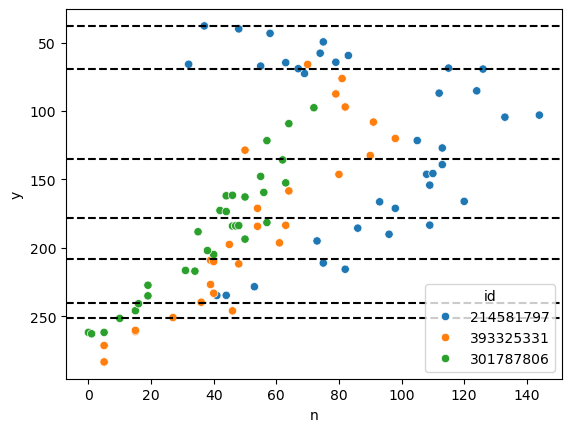

In [61]:
ax = sns.scatterplot(data=df,x='n',y='y',hue='id')#,legend=False)
# ax.set_aspect('equal', adjustable='datalim') 
ax.invert_yaxis()
for y_ in [2365*16, 4344*16, 8432*16, 11138*16, 13021*16, 15045*16, 15700*16]:
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')

In [45]:
edges = array([2365, 4344, 8432, 11138, 13021, 15045, 15700])*16/1000

for i,v in enumerate(edges[0:-1]):
    w = edges[i+1]
    u = df[(df['y']>v) & (df['y']<w)]['n'].mean()
    print(f'{u} spines per 5microns from {v} to {w} microns in molec layer')

67.42857142857143 spines per 5microns from 37.84 to 69.504 microns in molec layer
114.28571428571429 spines per 5microns from 69.504 to 134.912 microns in molec layer
107.28571428571429 spines per 5microns from 134.912 to 178.208 microns in molec layer
91.0 spines per 5microns from 178.208 to 208.336 microns in molec layer
59.0 spines per 5microns from 208.336 to 240.72 microns in molec layer
nan spines per 5microns from 240.72 to 251.2 microns in molec layer


In [33]:
df['y']

0     228.496
1     146.304
2      65.904
3      65.904
4     234.928
5     215.728
6     195.040
7     183.488
8     185.680
9     171.216
10    154.240
11    139.232
12    121.664
13    103.056
14     87.008
15    166.448
16     69.408
17     59.504
18     57.808
19     64.416
20     67.232
21     72.640
22     69.136
23     64.704
24    234.800
25    211.184
26    190.160
27    166.128
28    145.728
29    127.088
30    104.560
31     85.328
32     68.688
33     49.552
34     43.296
35     40.048
36     37.872
Name: y, dtype: float64